In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import required libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

2021-08-24 17:15:00.360060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:
2021-08-24 17:15:00.360080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [40]:
df_train = pd.read_json('~/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/train.json')
data_train = df_train.T
df_val = pd.read_json('/home/zac/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/val.json')
data_val = df_val.T
df_test = pd.read_json('~/code/Em3line/Butterfly_identification/Butterfly_identification/rawdata/ETHEC_dataset/splits/test.json')
data_test = df_test.T

In [4]:
data_train['species'] = data_train['genus'] +'_'+ data_train['specific_epithet']

In [5]:
data_val['species'] = data_val['genus'] +'_'+ data_val['specific_epithet']

In [6]:
data_train['full_image_path'] = data_train['image_path'] + '/' + data_train['image_name']

In [7]:
data_val['full_image_path'] = data_val['image_path'] + '/' + data_val['image_name']

In [8]:
sub_data_train = data_train.sample(n=1000, random_state=818)

In [9]:
sub_data_train.shape

(1000, 17)

In [42]:
sub_data_val = data_val.sample(n=200, random_state=818)

In [43]:
sub_data_test = data_test.sample(n=200, random_state=818)

In [11]:
FOLDER_PATH = '../Butterfly_identification/rawdata/ETHEC_dataset/IMAGO_build_test_resized/'

In [12]:
sub_data_train.species.drop_duplicates().count()

248

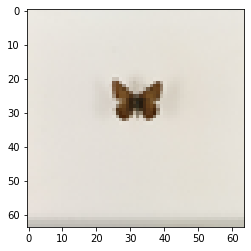

In [13]:
image = Image.open(FOLDER_PATH+sub_data_train.full_image_path[0])
image = image.resize((64,64))
image = np.asarray(image)
plt.imshow(image)

In [14]:
image.size

12288

In [15]:
type(image)

numpy.ndarray

In [16]:
sub_data_train[sub_data_train['species']=='Lycaena_tityrus']

,author,barcode,country,dec_lat,dec_long,family,genus,image_name,image_path,infraspecific_epithet,primary_division,specific_epithet,subfamily,subspecific_epithet,token,species,full_image_path
1a835dcd-0aaa-4cfe-869b-e3c200d63496,"(Poda, 1761)",ETHZ-ENT0013889,Switzerland,47.19515,8.78223,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011697.JPG,2017_04_05R,None,Schwyz,tityrus,Lycaeninae,tityrus,1a835dcd-0aaa-4cfe-869b-e3c200d63496,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011697.JPG
ebb70b82-6e7a-4d00-8cba-f3c6bf52b6cf,"(Poda, 1761)",ETHZ-ENT0013788,Switzerland,45.86666,8.98332,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_04_011573.JPG,2017_04_04R,None,Ticino,tityrus,Lycaeninae,tityrus,ebb70b82-6e7a-4d00-8cba-f3c6bf52b6cf,Lycaena_tityrus,2017_04_04R/ETHZ_ENT01_2017_04_04_011573.JPG
b0f34609-ac6c-45b7-b895-cf6d873ef5b8,"(Poda, 1761)",ETHZ-ENT0013792,Switzerland,46.32502,7.9879,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_04_011577.JPG,2017_04_04R,None,Valais,tityrus,Lycaeninae,tityrus,b0f34609-ac6c-45b7-b895-cf6d873ef5b8,Lycaena_tityrus,2017_04_04R/ETHZ_ENT01_2017_04_04_011577.JPG
38fbda71-0a33-4e44-89e3-261485a70128,"(Poda, 1761)",ETHZ-ENT0013888,Switzerland,47.36749,8.56783,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011695.JPG,2017_04_05R,None,Zurich,tityrus,Lycaeninae,tityrus,38fbda71-0a33-4e44-89e3-261485a70128,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011695.JPG
f9463970-5137-426c-aa89-5089013ade72,"(Speyer, 1851)",ETHZ-ENT0014031,Switzerland,46.793029,9.821343,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011857.JPG,2017_04_05R,None,Grisons,tityrus,Lycaeninae,subalpina,f9463970-5137-426c-aa89-5089013ade72,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011857.JPG
0d7c2d00-7122-4faa-93e2-b677f62806ef,"(Poda, 1761)",ETHZ-ENT0013806,Switzerland,46.24799,8.708,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011596.JPG,2017_04_05R,None,Ticino,tityrus,Lycaeninae,tityrus,0d7c2d00-7122-4faa-93e2-b677f62806ef,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011596.JPG
3de15d03-f1d9-49fc-81ce-efcd4667d97a,"(Poda, 1761)",ETHZ-ENT0013852,Switzerland,47.54228,8.20139,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011653.JPG,2017_04_05R,None,Aargau,tityrus,Lycaeninae,tityrus,3de15d03-f1d9-49fc-81ce-efcd4667d97a,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011653.JPG
c973cf39-a825-488a-afc9-446ce4f77b0b,"(Poda, 1761)",ETHZ-ENT0013799,Switzerland,47.43205,8.5634,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011588.JPG,2017_04_05R,None,Zurich,tityrus,Lycaeninae,tityrus,c973cf39-a825-488a-afc9-446ce4f77b0b,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011588.JPG
8c5a6f76-e513-44d4-b0b4-8af8ec2c3569,"(Poda, 1761)",ETHZ-ENT0013833,Italy,37.316667,13.666667,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011628.JPG,2017_04_05R,None,Sicily,tityrus,Lycaeninae,tityrus,8c5a6f76-e513-44d4-b0b4-8af8ec2c3569,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011628.JPG
4f4f56ce-d159-4084-9186-c66bc1d944b6,"(Poda, 1761)",ETHZ-ENT0013882,Switzerland,46.836111,9.559722,Lycaenidae,Lycaena,ETHZ_ENT01_2017_04_05_011685.JPG,2017_04_05R,None,Grisons,tityrus,Lycaeninae,tityrus,4f4f56ce-d159-4084-9186-c66bc1d944b6,Lycaena_tityrus,2017_04_05R/ETHZ_ENT01_2017_04_05_011685.JPG


In [17]:
images_train = []
for image in sub_data_train.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((96,96))
    tmp = np.asarray(tmp)
    images_train.append(tmp)
images_train = np.array(images_train)

In [18]:
images_train.shape

(1000, 96, 96, 3)

In [19]:
images_train[0].shape

(96, 96, 3)

In [20]:
images_val = []
for image in sub_data_val.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((96,96))
    tmp = np.asarray(tmp)
    images_val.append(tmp)
images_val = np.array(images_val)

In [21]:
images_val.shape

(200, 96, 96, 3)

In [22]:
base_model=MobileNetV2(weights='imagenet', input_shape=images_train[0].shape,include_top=False)

2021-08-24 17:15:22.431202: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-24 17:15:22.487216: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-24 17:15:22.487239: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zac-GF75-Thin-9RCX): /proc/driver/nvidia/version does not exist
2021-08-24 17:15:22.487633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
base_model.trainable=False

In [24]:
y = sub_data_train['species']
y_val = sub_data_val['species']

In [25]:
y_val.shape

(200,)

In [26]:
images_train.shape

(1000, 96, 96, 3)

In [27]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
'''x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3'''
x=Dense(130, activation = 'relu')(x)

In [28]:
preds=Dense(sub_data_train.species.drop_duplicates().count(),activation='softmax')(x) #final layer with softmax activation for N classes

In [29]:
model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

In [30]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [32]:
es = EarlyStopping(patience = 5)

In [33]:
y = np.array(y).reshape(1000, 1)
y_val = np.array(y_val).reshape(200,1)

In [34]:
y

array([['Lycaena_tityrus'],
       ['Clossiana_titania'],
       ['Argynnis_paphia'],
       ['Nymphalis_antiopa'],
       ['Cupido_minimus'],
       ['Euphydryas_cynthia'],
       ['Erebia_aethiops'],
       ['Thymelicus_sylvestris'],
       ['Melitaea_didyma'],
       ['Coenonympha_tullia'],
       ['Aricia_artaxerxes'],
       ['Colias_hyale'],
       ['Pieris_bryoniae'],
       ['Pieris_bryoniae'],
       ['Anthocharis_cardamines'],
       ['Plebejus_idas'],
       ['Erebia_triaria'],
       ['Brenthis_daphne'],
       ['Leptidea_sinapis'],
       ['Polyommatus_dorylas'],
       ['Plebejidea_loewii'],
       ['Fabriciana_adippe'],
       ['Erebia_meolans'],
       ['Polyommatus_icarus'],
       ['Lycaena_virgaureae'],
       ['Erebia_mnestra'],
       ['Plebejus_idas'],
       ['Vanessa_cardui'],
       ['Boloria_napaea'],
       ['Lycaena_virgaureae'],
       ['Parnassius_mnemosyne'],
       ['Plebejus_idas'],
       ['Araschnia_levana'],
       ['Maniola_jurtina'],
       ['Colia

In [35]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(y)
y_cat = ohe.transform(y)
y_val_cat = ohe.transform(y_val)



In [36]:
pd.DataFrame(y_val_cat).sum().sum()

167.0

In [37]:
history = model.fit(x = images_train,
         y = y_cat,
         validation_data=(images_val, y_val_cat),
         batch_size = 32,
         epochs = 50,
         callbacks = [es])

2021-08-24 17:15:24.864323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-24 17:15:24.884618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


Epoch 1/50
32/32 [==============================] - 4s 96ms/step - loss: 5.3241 - accuracy: 0.0500 - val_loss: 4.2130 - val_accuracy: 0.0750
Epoch 2/50
32/32 [==============================] - 2s 78ms/step - loss: 4.7264 - accuracy: 0.1070 - val_loss: 3.9261 - val_accuracy: 0.0800
Epoch 3/50
32/32 [==============================] - 2s 77ms/step - loss: 4.3071 - accuracy: 0.1360 - val_loss: 3.6575 - val_accuracy: 0.1200
Epoch 4/50
32/32 [==============================] - 2s 77ms/step - loss: 3.9210 - accuracy: 0.1800 - val_loss: 3.4201 - val_accuracy: 0.1450
Epoch 5/50
32/32 [==============================] - 2s 77ms/step - loss: 3.6008 - accuracy: 0.2410 - val_loss: 3.2035 - val_accuracy: 0.1700
Epoch 6/50
32/32 [==============================] - 2s 76ms/step - loss: 3.2769 - accuracy: 0.2910 - val_loss: 2.9999 - val_accuracy: 0.1950
Epoch 7/50
32/32 [==============================] - 3s 83ms/step - loss: 3.0127 - accuracy: 0.3120 - val_loss: 2.8521 - val_accuracy: 0.2200
Epoch 8/50
32

In [38]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

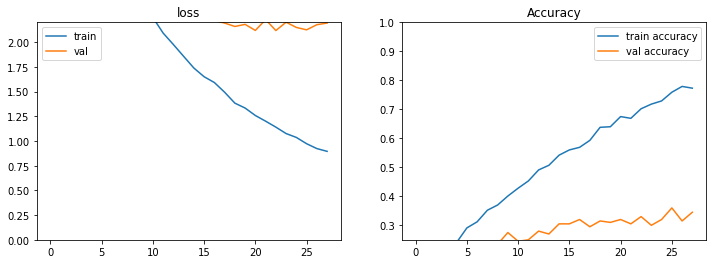

In [39]:
plot_history(history)

In [41]:
data_test['species'] = data_test['genus'] +'_'+ data_test['specific_epithet']
data_test['full_image_path'] = data_test['image_path'] + '/' + data_test['image_name']

In [44]:
images_test = []
for image in sub_data_test.full_image_path:
    tmp = Image.open(FOLDER_PATH+image)
    tmp = tmp.resize((96,96))
    tmp = np.asarray(tmp)
    images_test.append(tmp)
images_test = np.array(images_test)

In [45]:
y_test = sub_data_test['species']

In [46]:
y_test = np.array(y_test).reshape(200,1)

In [47]:
y_test_cat = ohe.transform(y_test)

In [48]:
model.evaluate(images_test, y_test_cat)

7/7 [==============================] - 0s 61ms/step - loss: 5.2127 - accuracy: 0.1950


[5.212707996368408, 0.19499999284744263]